## **Libraries**



In [ ]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("white")
import matplotlib.pyplot as plt
import string
from pickle import dump
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
import warnings
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.text import TextCollection
from sklearn.ensemble import RandomForestClassifier
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
nltk.download('stopwords')
nltk.download("wordnet")
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## **1. Data Loading**



In [ ]:
emails_df = pd.read_json("hf://datasets/yxzwayne/email-spam-10k/email-spam-10k.json")
emails_df = emails_df.rename(columns={"is_spam": "spam"})

In [ ]:
emails_df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [ ]:
emails_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10899 entries, 0 to 10898
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10899 non-null  object
 1   spam    10899 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 170.4+ KB


In [ ]:
emails_df.describe()

,spam
count,10899.000000
mean,0.263052
std,0.440310
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


## **2. Data Visualization**

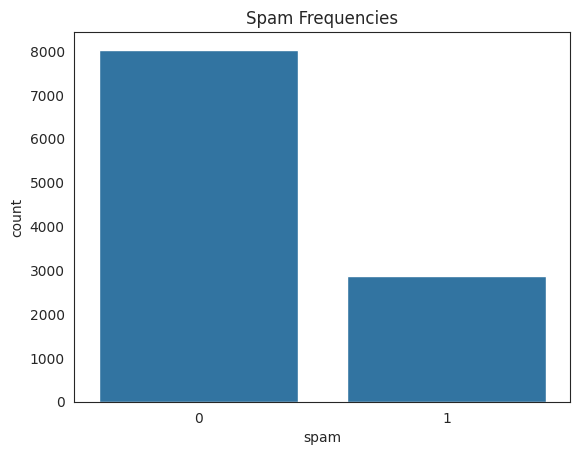

In [ ]:
# visualize spam frequencies
plt.figure(dpi=100)
sns.countplot(x="spam", data=emails_df)
plt.title("Spam Frequencies")
plt.show()


## **3. Data Cleaning**

In [ ]:
# Check for missing data for each column
emails_df.isnull().sum()

,0
text,0
spam,0


In [ ]:
# Check for duplicates and remove them
emails_df.drop_duplicates(inplace=True)

In [ ]:
def preprocess_text(text):
    # Remove "Subject:" from each text row
    text = re.sub(r"^subject:", "", text, flags=re.IGNORECASE).strip()
    wordnet_lemmatizer = WordNetLemmatizer()
    lowercase_sentence = text.lower()
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(lowercase_sentence)
    processed = []
    for token in tokens:
        if token not in stop_words and token not in string.punctuation and token.isalpha():
            lemmatized = wordnet_lemmatizer.lemmatize(token)
            processed.append(lemmatized)
    return processed

In [ ]:
emails_df["preprocessed"] = emails_df["text"].apply(preprocess_text)
emails_df.head()

,text,spam,preprocessed
0,Subject: naturally irresistible your corporate...,1,"[naturally, irresistible, corporate, identity,..."
1,Subject: the stock trading gunslinger fanny i...,1,"[stock, trading, gunslinger, fanny, merrill, m..."
2,Subject: unbelievable new homes made easy im ...,1,"[unbelievable, new, home, made, easy, im, want..."
3,Subject: 4 color printing special request add...,1,"[color, printing, special, request, additional..."
4,"Subject: do not have money , get software cds ...",1,"[money, get, software, cd, software, compatibi..."


## **4. Feature Extration**

In [ ]:
# Convert the list of words in 'preprocessed' column to a string format
emails_df['preprocessed_str'] = emails_df['preprocessed'].apply(lambda x: ' '.join(x))

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Apply TF-IDF on the 'preprocessed_str' column
tfidf_matrix = tfidf_vectorizer.fit_transform(emails_df['preprocessed_str'])
tfidf_matrix

<10688x59999 sparse matrix of type '<class 'numpy.float64'>'
	with 789279 stored elements in Compressed Sparse Row format>

## **5. Data Splitting**

In [ ]:
# Step 3: Split Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_matrix, emails_df['spam'], test_size=0.20, random_state=0, stratify=emails_df['spam']
)

print("Original training class distribution:")
print(y_train.value_counts())

Original training class distribution:
spam
0    6286
1    2264
Name: count, dtype: int64


## **5. Applying SMOTE for Resampling**

In [ ]:
# Step 4: Apply SMOTE for Resampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nResampled training class distribution:")
print(pd.Series(y_train_resampled).value_counts())



Resampled training class distribution:
spam
1    6286
0    6286
Name: count, dtype: int64


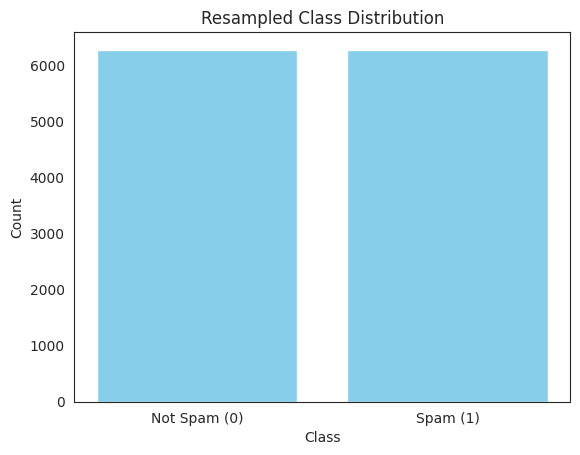

In [ ]:
# Step 5: Visualize Resampled Data Distribution
resampled_distribution = pd.Series(y_train_resampled).value_counts()
plt.bar(resampled_distribution.index, resampled_distribution.values, color='skyblue')
plt.xticks([0, 1], labels=['Not Spam (0)', 'Spam (1)'])
plt.title('Resampled Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [ ]:
## X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, emails_df['spam'], test_size=0.20, random_state=0)

## **6. The Model**

In [ ]:
# Model creation
model = MultinomialNB()
clf = LogisticRegression(random_state=0)

In [ ]:
models = [model, clf]

In [ ]:
def modelTrainAndPredict(model):
  model.fit(X_train_resampled, y_train_resampled)
  y_pred = model.predict(X_test)
  return y_pred

In [ ]:
def calcAccuracy(y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  accuracy = accuracy * 100
  return accuracy

In [ ]:
prediction = {}

for model in models:
  y_pred = modelTrainAndPredict(model)
  accuracy = calcAccuracy(y_pred)
  prediction[model] = {"accuracy": accuracy, "y_pred": y_pred}

print(prediction)

{MultinomialNB(): {'accuracy': 98.36295603367633, 'y_pred': array([0, 0, 0, ..., 0, 0, 0])}, LogisticRegression(random_state=0): {'accuracy': 97.56782039289055, 'y_pred': array([0, 0, 0, ..., 0, 0, 0])}}


In [ ]:
# Model Evaluation | Classification report
for values in prediction.values():
  report = classification_report(y_test, values["y_pred"])
  print("Report:", report)

Report:               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1572
           1       0.96      0.97      0.97       566

    accuracy                           0.98      2138
   macro avg       0.98      0.98      0.98      2138
weighted avg       0.98      0.98      0.98      2138

Report:               precision    recall  f1-score   support

           0       1.00      0.97      0.98      1572
           1       0.92      1.00      0.96       566

    accuracy                           0.98      2138
   macro avg       0.96      0.98      0.97      2138
weighted avg       0.98      0.98      0.98      2138



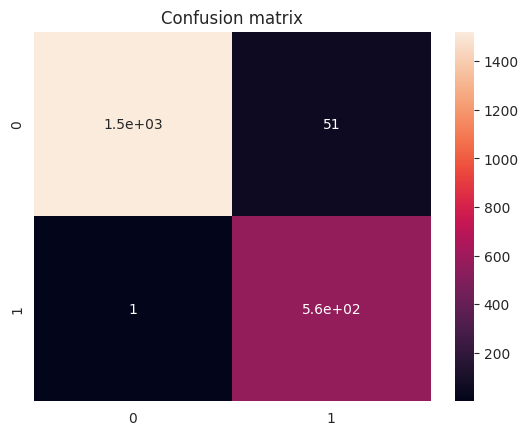

In [ ]:
# Model Evaluation | Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(dpi=100)
sns.heatmap(cm, annot=True)
plt.title("Confusion matrix")
plt.show()